In [11]:
import shutil
# loading data into python structures
try:
    shutil.rmtree("data/dnd-cnn-split/train")
    shutil.rmtree("data/dnd-cnn-split/test")
except:
    pass

In [12]:
import os
# ensure directories exist
from pathlib import Path

Path("data/dnd-cnn-split/train/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/train/no-damage").mkdir(parents=True, exist_ok=True)

Path("data/dnd-cnn-split/test/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/test/no-damage").mkdir(parents=True, exist_ok=True)


In [13]:
all_damage_file_paths = os.listdir('dataset/Project3/damage')
all_no_damage_file_paths = os.listdir('dataset/Project3/no_damage')

In [14]:
import random

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))


train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train no damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test no damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))


train damage image count:  11336
test damage image count:  2834
len of overlap:  0
train no damage image count:  5721
test no damage image count:  1431
len of overlap:  0


In [23]:
# ensure to copy the images to the directories
import shutil
for p in train_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/train/damage', p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/test/damage', p) )

for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/train/no-damage', p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/test/no-damage', p) )



# check counts:
print("Files in train/damage: ", len(os.listdir("data/dnd-cnn-split/train/damage")))
print("Files in train/no-damage: ", len(os.listdir("data/dnd-cnn-split/train/no-damage")))

print("Files in test/damage: ", len(os.listdir("data/dnd-cnn-split/test/damage")))
print("Files in test/no-damage: ", len(os.listdir("data/dnd-cnn-split/test/no-damage")))

# shape of damage and no damage training/testing files


Files in train/damage:  11336
Files in train/no-damage:  5721
Files in test/damage:  2834
Files in test/no-damage:  1431


In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# path to training data
train_data_dir = 'data/dnd-cnn-split/train'

# controls the size of the "batches" of images streamed when accessing the datasets.
# this is useful to control the memory usage with very large datasets
batch_size = 32

# target image size
img_height = 150
img_width = 150

# note that the subset parameter can take values of "training", "validation", or "both";
# the value dictates which dataset is returned (we want both)
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# rescale instance
rescale = Rescaling(scale=1.0/255)

# apply the rescale to the train and validation sets
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))


Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Using 3411 files for validation.


In [24]:
# path to test data
test_data_dir = 'data/dnd-cnn-split/test/'

# we do not set subset=both here because we do not want the test set split
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
)

# approach 1: manually rescale data --
rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 4265 files belonging to 2 classes.


In [25]:
for images, labels in train_ds.take(1):  # Take one batch
    print("Train batch shape:", images.shape)  # Shape: (batch_size, height, width, channels)
    print("Train labels shape:", labels.shape)  # Shape: (batch_size,)


Train batch shape: (32, 150, 150, 3)
Train labels shape: (32,)


In [26]:
for images, labels in test_ds.take(1):
    print("Test batch shape:", images.shape)
    print("Test labels shape:", labels.shape)


Test batch shape: (32, 150, 150, 3)
Test labels shape: (32,)


Label for each of the above images: [0 1 1 0 0]


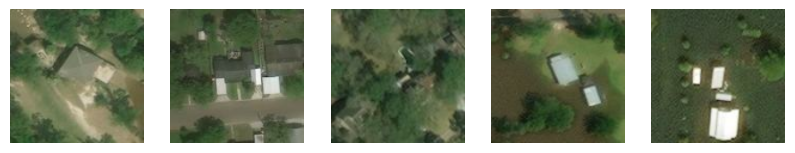

In [29]:
import matplotlib.pyplot as plt

# Get one batch of images and labels from the rescaled dataset
for images, labels in train_rescale_ds.take(1):  
    X_train_batch = images.numpy()  # Convert to NumPy array
    y_train_batch = labels.numpy()  # Convert labels to NumPy
    break

# Plot the first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_batch[i])  # No need for uint8 conversion since values are [0,1]
    plt.axis("off")

print('Label for each of the above images:', y_train_batch[:5])


In [30]:
# creating ANN model
def create_perceptron(dim):
    """
    Create a perceptron of dimension `dim` and initialize it with random weights.
    """
    # we use dim+1 because we want to have a bias term and `dim` weights
    return np.random.random(dim+1)

In [31]:
def create_layer(num_perceptrons, dim, activation_function):
    """
    Create a layer of `num_perceptrons` perceptron, each of dimension `dim` with activation function `activation_function`.
    Initialize the weights of all perceptrons to a random float between 0 and 1.
    """
    # represent the layer as a list of dictionary of perceptrons
    layer = []
    for i in range(num_perceptrons):
        layer.append({"weights": create_perceptron(dim), "activation_function": activation_function})
    return layer

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(128, activation='relu'),  # Hidden layer with ReLU
    Dense(64, activation='relu'),   # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8648449 (32.99 MB)
Trainable params: 8648449 (32.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Train the model
history = model.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=10,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/10
427/427 [==============================] - 23s 53ms/step - loss: 1.1369 - accuracy: 0.6323 - val_loss: 0.6662 - val_accuracy: 0.6919
Epoch 2/10
427/427 [==============================] - 24s 55ms/step - loss: 0.6349 - accuracy: 0.6801 - val_loss: 0.6253 - val_accuracy: 0.6752
Epoch 3/10
427/427 [==============================] - 25s 59ms/step - loss: 0.5731 - accuracy: 0.7146 - val_loss: 0.5555 - val_accuracy: 0.7482
Epoch 4/10
427/427 [==============================] - 25s 59ms/step - loss: 0.5637 - accuracy: 0.7262 - val_loss: 0.5449 - val_accuracy: 0.7464
Epoch 5/10
427/427 [==============================] - 26s 61ms/step - loss: 0.5941 - accuracy: 0.6898 - val_loss: 0.5878 - val_accuracy: 0.6681
Epoch 6/10
427/427 [==============================] - 26s 60ms/step - loss: 0.5909 - accuracy: 0.6637 - val_loss: 0.5887 - val_accuracy: 0.6681
Epoch 7/10
427/427 [==============================] - 25s 59ms/step - loss: 0.5779 - accuracy: 0.6637 - val_loss: 0.5725 - val_accuracy:

In [34]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_rescale_ds)
print(f"Test Accuracy: {test_acc:.4f}")


134/134 [==============================] - 1s 6ms/step - loss: 0.5988 - accuracy: 0.6525
Test Accuracy: 0.6525


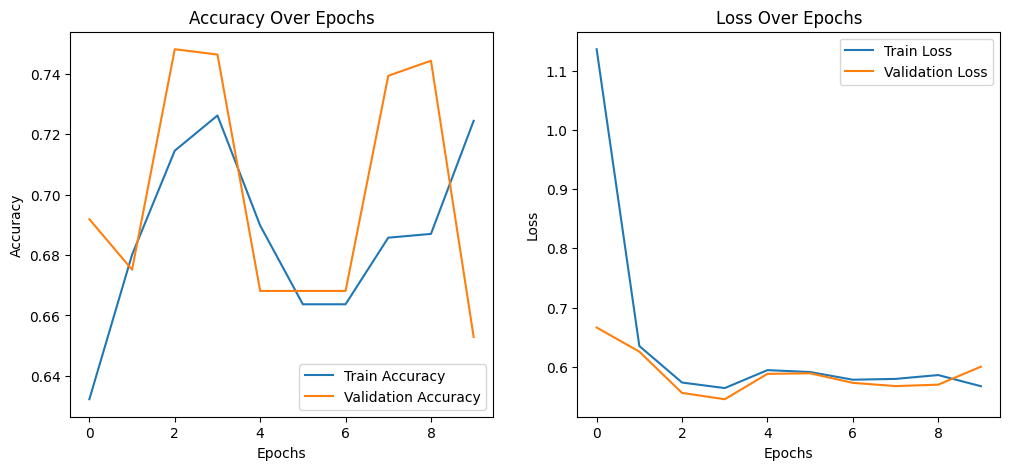

In [35]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()


1/1 [==============================] - 0s 70ms/step


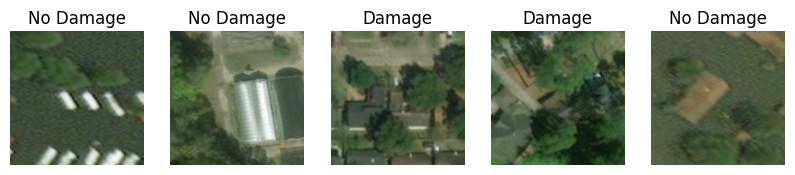

In [36]:
import numpy as np

# Get a batch of test images and labels
for images, labels in test_rescale_ds.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype("int")  # Convert probabilities to 0 or 1
    break

# Display results
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].numpy())  
    plt.axis("off")
    plt.title("Damage" if preds[i] == 1 else "No Damage")

plt.show()
